# Lab 4: Prompt-learning and LoRA.

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bbnfiru5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bbnfiru5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import io
import clip
import pyarrow as pa
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader
from typing import List, Union
import random



import numpy as np
from matplotlib import pyplot as plt

from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
)

CLASSES_CIFAR10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Part 1. Prompt/Few-Shot learning

In this part, we will focus on prompt/few-shot learning with CLIP on the CIFAR-10 dataset.

### **Question 1.1**

Evaluate CLIP zero-shot performances on CIFAR-10.

Tip.  CIFAR-10 classes are stored in the list `CLASSES_CIFAR10`.

In [4]:
# - function to evaluate CLIP
def evaluate_clip(model, test_loader, classes, prefix, device):
    """
    Function to evaluate the model in a zero-shot setting.

    Parameters
    ----------
    model : clip model
        The model to evaluate.
    test_loader : torch.utils.data.DataLoader
        The test loader.
    classes : list
        List of classes.
    prefix : str
        Prefix to add to the classes.
        e.g. "This a photo of"
    """
    ### Comeplete the following code
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    test_images = []

    # Prepare text prompts for each class
    text_inputs = torch.cat([clip.tokenize(f"{prefix} {c}") for c in classes]).to(device)

    with torch.no_grad():
        # Encode text inputs with CLIP
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize text embeddings

        for images, labels in tqdm(test_loader, desc="Evaluating CLIP Zero-Shot Performance"):
            images = images.to(device)
            labels = labels.to(device)

            # Encode images with CLIP
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize image embeddings

            # Compute similarity scores between images and text
            similarities = (image_features @ text_features.T)  # Cosine similarity
            predictions = similarities.argmax(dim=-1)  # Get class with highest similarity

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store images
            test_images.extend(images.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total
    print(f"Test Acc: {test_acc:.3f}")
    return test_acc, all_preds, all_labels, test_images



def display_results(images: List[Union[torch.Tensor, np.ndarray]],
    labels: List[int],
    preds: List[int],
    classes: List[str],
    num_images: int = 8
    ) -> None:
    """
    Display test images with actual and predicted class labels.

    Parameters
    ----------
    images : list of torch.Tensor or np.ndarray
        Test images.
    labels : list
        Ground truth labels.
    preds : list
        Predicted labels.
    classes : list
        CIFAR-10 class names.
    num_images : int, optional
        Number of images to display (default 8).
    """
    fig, axes = plt.subplots(2, num_images // 2, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break

       # Ensure image is in correct format
        img = images[i]

        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy format
        elif isinstance(img, np.ndarray):
            img = np.transpose(img, (1, 2, 0))  # Convert (C, H, W) -> (H, W, C)

        # Normalize image to [0,1] for display
        img = (img - img.min()) / (img.max() - img.min())


        true_label = classes[labels[i]]
        pred_label = classes[preds[i]]

        ax.imshow(img)
        ax.set_title(f"GT: {true_label}\nPred: {pred_label}",
                     color="green" if true_label == pred_label else "red")
        ax.axis("off")

    plt.show()

In [5]:
# - load the model
model, preprocess = clip.load("ViT-B/32", device=device)

# - load the data
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 30.5MiB/s]


100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Evaluating CLIP Zero-Shot Performance: 100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Test Acc: 0.824

Final Zero-Shot Accuracy on CIFAR-10: 0.824


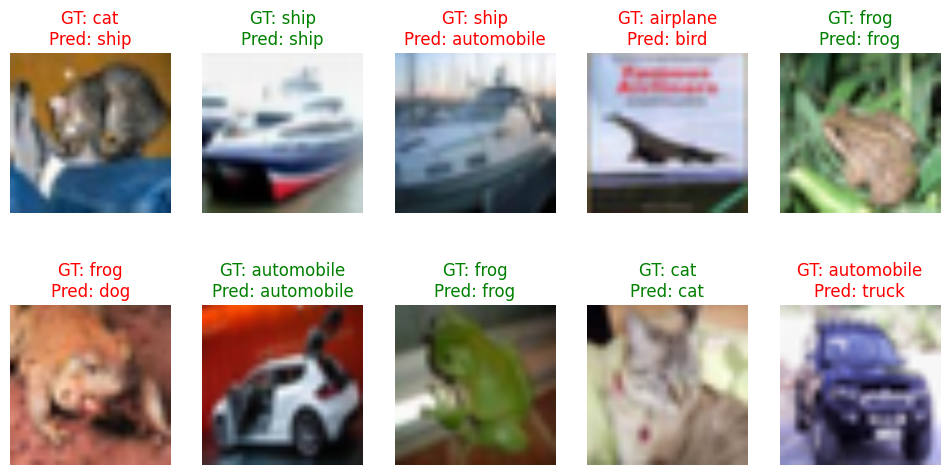

In [6]:
accuracy, all_preds, all_labels, test_images = evaluate_clip(model,
              test_loader=test_loader,
              classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
              prefix="",
              device=device)

print(f"\nFinal Zero-Shot Accuracy on CIFAR-10: {accuracy:.3f}")

# Display Some Actual vs Predicted Images
display_results(test_images, all_labels, all_preds, CLASSES_CIFAR10, num_images=10)

### **Question 1.2**
Explore 2 or 3 prompts to evaluate CLIP on CIFAR-10, e.g. you can use "A photo of {CLASS}".
How much can you gain by changing the prompts?

Promt: An object that resembles a


Evaluating CLIP Zero-Shot Performance: 100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Test Acc: 0.842


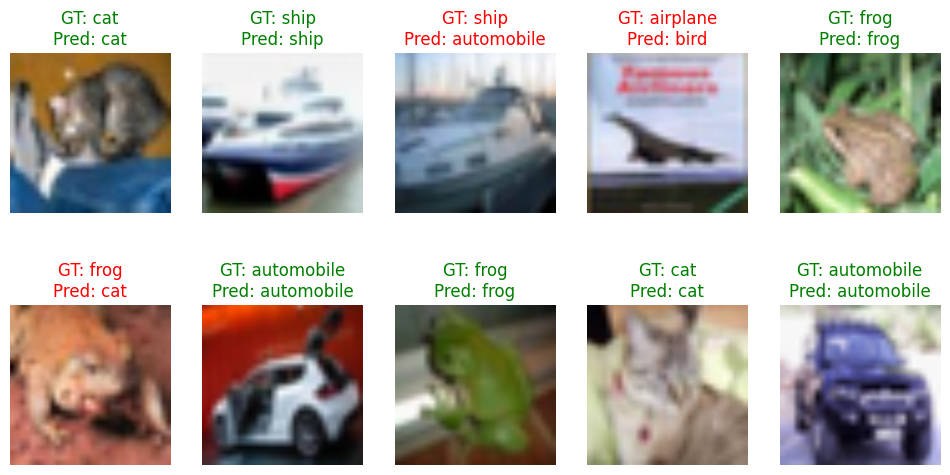

In [7]:
print(f"Promt: An object that resembles a")
accuracy, all_preds, all_labels, test_images = evaluate_clip(model,
                                                    test_loader=test_loader,
                                                    classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
                                                    prefix="An object that resembles a",
                                                    device=device)
display_results(test_images, all_labels, all_preds, CLASSES_CIFAR10, num_images=10)

Promt: A small resolution image of a


Evaluating CLIP Zero-Shot Performance: 100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


Test Acc: 0.825


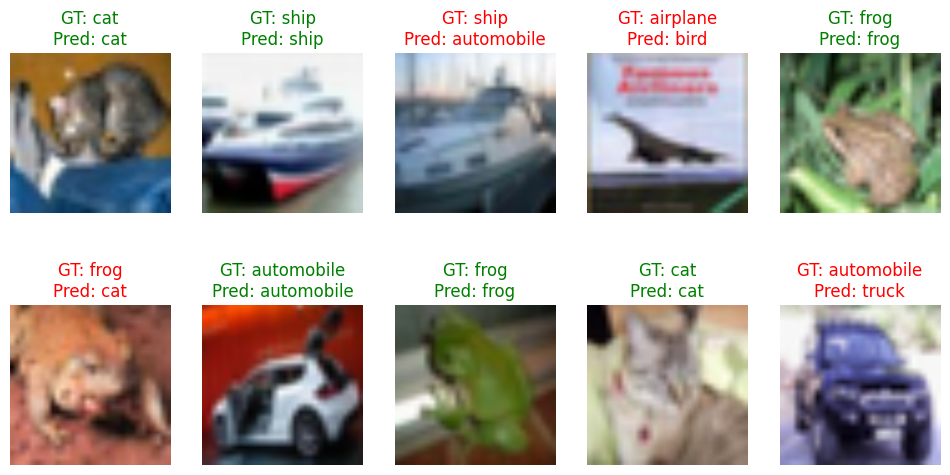

In [8]:
print("Promt: A small resolution image of a")
accuracy, all_preds, all_labels, test_images = evaluate_clip(model,
                                                  test_loader=test_loader,
                                                  classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
                                                  prefix="A small resolution image of a", # CIFAR-10 images are 32x32 by default
                                                  device=device)

display_results(test_images, all_labels, all_preds, CLASSES_CIFAR10, num_images=10)

## CoOp

As you may have noticed, changing the prompt can significantly impact the model's performance. However, crafting the perfect prompt is a challenging task that requires extensive experimentation. To address this issue, Context Optimization (CoOp) [Zhou et al, 2022] introduced a novel method for adapting CLIP to downstream classification tasks, bypassing the need for manual prompt engineering.

CoOp aims to learn a prompt called **learnable context** (only a few trainable parameters compared to finetuning the entire model)  to enhance the model's performance on the downstream task.


Here is a figure of the CoOp approach:

<img src="https://jumdc.github.io/assets/img/coop.png" width=768>


The prompt given to the text encoder $g(·)$ will be of the form $t = [\text{SOS}][V]_1[V]_2 . . . [V]_M[\text{CLASS}][\text{EOS}]$ where each $[V]_m, (m ∈ {1, . . . , M})$ is a vector with the same dimension as word embeddings, $M$ is a hyperparameter specifying the number of context tokens, [SOS] and [EOS] are the special tokens indicating the start and end of the sentence (the same as in the pre-trained CLIP model). The context tokens $[V]_m$ are initialized randomly and learned during training. By forwarding a prompt $t$ to the text encoder g(·), we can obtain a classification weight vector representing a visual concept (still from the [EOS] token position). The prompt can then be trained using a cross-entropy between the classification weight vector and the one-hot label vector of the input image.


Let's now implement the CoOp approach.
Code-wise CoOp relies on a pretrained CLIP with a few modifications.

Note on [SOS] and [EOS] tokens:
- Tokenization is the process of converting text into a sequence of tokens, which can be words, subwords, or characters. These tokens are the smallest units of meaning in a text that can be processed by a language model. For example, the sentence “Hello, world!” can be tokenized into [“Hello”, “,”, “world”, “!”]. Tokenization simplifies the text and allows the model to work with manageable chunks of data.
- The [SOS] token is a special token that indicates the start of a sentence. The [EOS] token is a special token that indicates the end of a sentence.

### **Question 1.3**

Implement the `LearnableContext` class. This class is designed to create the learnable prompt for a CLIP model, enabling it to adapt dynamically to specific classification tasks.

The LearnableContext class should do the following:

- Initializes a set of learnable context tokens (ctx) to adapt prompts dynamically.
- Prepares token embeddings that include a prefix ([SOS] token embedding) and a suffix (class name and [EOS] tokens embedding) for each class.
- Constructs the full prompt embeddings by combining the prefix, learnable context, and suffix during the forward pass.

Example of the learnable context for CIFAR-10:
> let `X` be a learnable context token, with `n_ctx=3`, the prompt for the class "airplane" would be: `[SOS] X X X airplane [EOS]` and for the class "automobile": `[SOS] X X X automobile [EOS]`.

Tip. You can use `clip_model.token_embedding()` to get the token embeddings.

In [9]:
class LearnableContext(nn.Module):
    def __init__(self,
            classnames: List[str],
            clip_model: nn.Module,
            device: str,
            n_ctx: int = 16
        ) -> None:
        """
        classnames: list of str
            A list of class names for classification.
        clip_model: torch.nn.Module
            Pretrained CLIP model.
        device: str
            Device to use.
        n_ctx: int
            Number of context words to learn.
        """
        super().__init__()
        # To complete

        self.classnames = classnames
        self.clip_model = clip_model
        self.device = device
        self.n_ctx = n_ctx
        self.d_model = clip_model.token_embedding.weight.shape[1]

        self.ctx = nn.Parameter(torch.randn(n_ctx, self.d_model))

        with torch.no_grad():
            dummy_tokens = clip.tokenize("a").to(device)
            sos_embedding = clip_model.token_embedding(dummy_tokens)[0, 0]  # Extract [SOS] token
        self.register_buffer("sos", sos_embedding.unsqueeze(0))

        # Prepare suffixes ([CLASS] + [EOS])
        suffix_list = []
        for classname in classnames:
            tokens = clip.tokenize(classname).to(device)
            class_tokens = tokens[0, 1:-1] if tokens.size(1) >= 3 else tokens[0, 1:]
            class_embeddings = clip_model.token_embedding(class_tokens)

            eos_token = tokens[0, -1].unsqueeze(0)
            eos_embedding = clip_model.token_embedding(eos_token)

            suffix = torch.cat([class_embeddings, eos_embedding], dim=0)
            suffix_list.append(suffix)

        self.register_buffer("suffixes", torch.stack(suffix_list, dim=0))

    def forward(self):
        """Forward pass of the LearnableContext.

        Returns:
        -------
        torch.Tensor
            The context vector for each class: [SOS] ctx [CLASS] [EOS]
        """
        num_classes = self.suffixes.shape[0]

        # Expand [SOS] and learnable context tokens for all classes
        sos_expanded = self.sos.unsqueeze(0).expand(num_classes, -1, -1)
        ctx_expanded = self.ctx.unsqueeze(0).expand(num_classes, -1, -1)

        # Combine: [SOS] + [CTX] + [CLASS] + [EOS]
        prompt_embeddings = torch.cat([sos_expanded, ctx_expanded, self.suffixes], dim=1)

        return prompt_embeddings

### **Question 1.4**

Implement the CoOp model.
The CoOpModel class performs the following tasks:
- Prompt Learning: Uses LearnableContext to generate learnable context tokens for each class, transforming them into dynamic text prompts.
- Text and Image Encoding: Encodes images with CLIP's visual encoder and encodes text prompts with the model's transformer and text projection.
- Logit Calculation: Computes cosine similarities between image and text features and outputs logits using a learned logit scale.

Tip:
You can implement the following methods in the CoOp Model class:
- `__init__`: Initializes the CoOp model with CLIP pretrained model (`clip.load("ViT-B/32", device="cuda")`) and the `LearnableContext` class.
- `encode_text`: Encodes the learnable prompts using the CLIP pretrained text encoder and projection head.
    It should:
    - Add the positional embedding to the input prompts (prompts).
    - Use the transformer to process the input sequence.
    - Apply the final layer normalization (ln_final) to the transformed sequence.
    - Extract the features corresponding to the end-of-text [EOS] token.
    - Project the resulting feature to the text projection space using text_projection.
    - CLIP uses a sequence-first approach for the Text model, so the input shape to the text encoder should be (sequence_length, batch_size, hidden_size).
- `forward`: Performs the forward pass computations for the CoOp model.



In [10]:
class CoOpModel(nn.Module):
    """CoOp model"""
    def __init__(self,
                 classnames: List[str],
                 clip_model: nn.Module,
                 device: str,
                 n_ctx: int = 16
                 ) -> None:

        """Initializes the CoOp model.

        Parameters
        ----------
        classnames: list of str
            A list of class names for classification.
        clip_model: torch.nn.Module
            Pretrained CLIP model.
        device: str
            Device to use.
        n_ctx: int
            Number of context words to learn.
        """
        super().__init__()
        self.clip_model = clip_model
        self.device = device
        self.prompt_learner = LearnableContext(n_ctx=n_ctx,
                                            device=device,
                                            classnames=classnames,
                                            clip_model=clip_model)
        # To complete
        # Logit scale (initialized with the same value as the pretrained CLIP)
        self.logit_scale = nn.Parameter(clip_model.logit_scale.clone().detach())

    def encode_text(self, prompts, tokenized_prompts):
        """
        Encodes the learnable text prompts using the CLIP model's transformer and projection layers.

        Parameters
        ----------
        prompts: torch.Tensor
            The learnable text prompts.
        tokenized_prompts: torch.Tensor
            The tokenized prompts -> the highest token in each sequence represents the [EOT].
        """
        # To complete
        # Add positional embeddings
        orig_pos_emb = self.clip_model.positional_embedding
        L_orig = orig_pos_emb.shape[0]
        L_new = prompts.shape[1]

        if L_new != L_orig:
            pos_emb = orig_pos_emb.unsqueeze(0).permute(0, 2, 1)
            pos_emb = F.interpolate(pos_emb, size=L_new, mode='linear', align_corners=False)
            pos_emb = pos_emb.permute(0, 2, 1).squeeze(0)
        else:
            pos_emb = orig_pos_emb
        pos_emb = pos_emb.to(prompts.dtype)

        x = prompts + pos_emb.unsqueeze(0)

        with torch.no_grad():
            new_mask = torch.empty(L_new, L_new, device=x.device, dtype=x.dtype).fill_(float("-inf"))
            new_mask.triu_(1)
            new_mask = new_mask.detach()
            for block in self.clip_model.transformer.resblocks:
                block.attn_mask = new_mask.clone()

        target_dtype = self.clip_model.transformer.resblocks[0].attn.in_proj_weight.dtype
        x = x.to(target_dtype)

        x = x.permute(1, 0, 2)
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.clip_model.ln_final(x)

        eos_indices = tokenized_prompts.argmax(dim=-1)
        x = x[torch.arange(x.shape[0]), eos_indices]
        x = x @ self.clip_model.text_projection

        for block in self.clip_model.transformer.resblocks:
            block.attn_mask = None

        return x

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """Given an image, returns the logits for each class."""
        # To complete
        # Encode images
        prompts = self.prompt_learner()
        prompt_length = prompts.shape[1]
        num_classes = prompts.shape[0]
        tokenized_prompts = torch.zeros((num_classes, prompt_length), dtype=torch.long, device=prompts.device)
        tokenized_prompts[:, -1] = 1  # Mark last token as [EOS]

        text_features = self.encode_text(prompts, tokenized_prompts)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        image_features = self.clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logit_scale = self.clip_model.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

#### **Question 1.5**
Train CoOpModel on CIFAR-10 using a Cross Entropy loss and log both train and test loss and accuracy. Since we are in a few-shot setting, **you can only use between 1 and 20 samples per class**. You should obtain at least 85+% test accuracy.

Hparameters are to be choosen to your discretion.

Tips:
- You can use `torch.utils.data.Subset` to create a subset of the CIFAR-10 dataset with a limited number of samples per class.

In [11]:
def coop_training_loop(n_epochs: int,
                       n_shot: int,
                       device: str,
                       lr: float,
                       n_ctx: int,
                       batch_size: int,
                       classes= None) -> nn.Module:
    # -- model
    clip_model = clip.load("ViT-B/32", device=device)[0]
    for param in clip_model.parameters():
        param.requires_grad = False
    coop_clip = CoOpModel(classnames=classes,
                        clip_model=clip_model,
                        device=device,
                        n_ctx=n_ctx
                        ).to(device)

    # -- data
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ]) # To complete
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ]) # To complete
    train_set = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
    test_set = torchvision.datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)

    # To complete

    # Create few-shot training subset
    targets = torch.tensor(train_set.targets)
    train_indices = []
    for class_idx in range(len(classes)):
        idxs = (targets == class_idx).nonzero(as_tuple=False).flatten()
        idxs = idxs[torch.randperm(len(idxs))]
        selected = idxs[:n_shot].tolist()
        train_indices.extend(selected)

    train_subset = Subset(train_set, train_indices)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(coop_clip.parameters(), lr=lr)

    for epoch in range(n_epochs):
        coop_clip.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = coop_clip(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = logits.max(dim=1)
            train_correct += preds.eq(labels).sum().item()
            train_total += labels.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total

        coop_clip.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Test]"):
                images, labels = images.to(device), labels.to(device)
                logits = coop_clip(images)
                loss = criterion(logits, labels)
                test_loss += loss.item() * images.size(0)
                _, preds = logits.max(dim=1)
                test_correct += preds.eq(labels).sum().item()
                test_total += labels.size(0)

        test_loss /= test_total
        test_acc = test_correct / test_total

        print(f"Epoch [{epoch+1}/{n_epochs}]  "
              f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
              f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")

    return coop_clip

In [12]:
coop_clip_trained = coop_training_loop(n_epochs=35,
                                device=device,
                                n_shot=20,
                                lr=0.001,
                                n_ctx=12,
                                batch_size=32,
                                classes=CLASSES_CIFAR10)

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch [1/35]  Train Loss: 1.9895  Train Acc: 0.5300  Test Loss: 1.9354  Test Acc: 0.5660


Epoch 2/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.27it/s]


Epoch [2/35]  Train Loss: 1.9004  Train Acc: 0.5450  Test Loss: 1.8508  Test Acc: 0.5702


Epoch 3/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch [3/35]  Train Loss: 1.8187  Train Acc: 0.5350  Test Loss: 1.7558  Test Acc: 0.5764


Epoch 4/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


Epoch [4/35]  Train Loss: 1.7153  Train Acc: 0.5550  Test Loss: 1.6456  Test Acc: 0.5965


Epoch 5/35 [Test]: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch [5/35]  Train Loss: 1.5949  Train Acc: 0.6100  Test Loss: 1.5094  Test Acc: 0.6412


Epoch 6/35 [Test]: 100%|██████████| 313/313 [00:20<00:00, 15.49it/s]


Epoch [6/35]  Train Loss: 1.4441  Train Acc: 0.6400  Test Loss: 1.3301  Test Acc: 0.6983


Epoch 7/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch [7/35]  Train Loss: 1.2550  Train Acc: 0.6900  Test Loss: 1.1177  Test Acc: 0.7649


Epoch 8/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch [8/35]  Train Loss: 1.0379  Train Acc: 0.7600  Test Loss: 0.9034  Test Acc: 0.8148


Epoch 9/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


Epoch [9/35]  Train Loss: 0.7987  Train Acc: 0.8300  Test Loss: 0.7220  Test Acc: 0.8278


Epoch 10/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch [10/35]  Train Loss: 0.6631  Train Acc: 0.8300  Test Loss: 0.6248  Test Acc: 0.8284


Epoch 11/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch [11/35]  Train Loss: 0.5908  Train Acc: 0.8400  Test Loss: 0.5671  Test Acc: 0.8318


Epoch 12/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


Epoch [12/35]  Train Loss: 0.5313  Train Acc: 0.8400  Test Loss: 0.5281  Test Acc: 0.8393


Epoch 13/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


Epoch [13/35]  Train Loss: 0.4952  Train Acc: 0.8400  Test Loss: 0.4968  Test Acc: 0.8502


Epoch 14/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch [14/35]  Train Loss: 0.4574  Train Acc: 0.8700  Test Loss: 0.4655  Test Acc: 0.8645


Epoch 15/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch [15/35]  Train Loss: 0.4283  Train Acc: 0.8900  Test Loss: 0.4342  Test Acc: 0.8751


Epoch 16/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


Epoch [16/35]  Train Loss: 0.3986  Train Acc: 0.8900  Test Loss: 0.4063  Test Acc: 0.8805


Epoch 17/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch [17/35]  Train Loss: 0.3698  Train Acc: 0.9000  Test Loss: 0.3892  Test Acc: 0.8840


Epoch 18/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.27it/s]


Epoch [18/35]  Train Loss: 0.3487  Train Acc: 0.9100  Test Loss: 0.3772  Test Acc: 0.8865


Epoch 19/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch [19/35]  Train Loss: 0.3488  Train Acc: 0.9050  Test Loss: 0.3689  Test Acc: 0.8886


Epoch 20/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch [20/35]  Train Loss: 0.3427  Train Acc: 0.8950  Test Loss: 0.3620  Test Acc: 0.8915


Epoch 21/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch [21/35]  Train Loss: 0.3083  Train Acc: 0.9200  Test Loss: 0.3569  Test Acc: 0.8917


Epoch 22/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch [22/35]  Train Loss: 0.3111  Train Acc: 0.9150  Test Loss: 0.3540  Test Acc: 0.8921


Epoch 23/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch [23/35]  Train Loss: 0.3024  Train Acc: 0.9150  Test Loss: 0.3506  Test Acc: 0.8937


Epoch 24/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch [24/35]  Train Loss: 0.2921  Train Acc: 0.9150  Test Loss: 0.3478  Test Acc: 0.8934


Epoch 25/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch [25/35]  Train Loss: 0.3006  Train Acc: 0.9100  Test Loss: 0.3452  Test Acc: 0.8930


Epoch 26/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch [26/35]  Train Loss: 0.2961  Train Acc: 0.9100  Test Loss: 0.3426  Test Acc: 0.8934


Epoch 27/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch [27/35]  Train Loss: 0.2957  Train Acc: 0.9100  Test Loss: 0.3402  Test Acc: 0.8926


Epoch 28/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


Epoch [28/35]  Train Loss: 0.2752  Train Acc: 0.9250  Test Loss: 0.3379  Test Acc: 0.8933


Epoch 29/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


Epoch [29/35]  Train Loss: 0.2934  Train Acc: 0.9300  Test Loss: 0.3358  Test Acc: 0.8936


Epoch 30/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch [30/35]  Train Loss: 0.2609  Train Acc: 0.9200  Test Loss: 0.3337  Test Acc: 0.8941


Epoch 31/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch [31/35]  Train Loss: 0.2597  Train Acc: 0.9200  Test Loss: 0.3320  Test Acc: 0.8948


Epoch 32/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch [32/35]  Train Loss: 0.2807  Train Acc: 0.9050  Test Loss: 0.3298  Test Acc: 0.8951


Epoch 33/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch [33/35]  Train Loss: 0.2432  Train Acc: 0.9200  Test Loss: 0.3276  Test Acc: 0.8958


Epoch 34/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch [34/35]  Train Loss: 0.2600  Train Acc: 0.9250  Test Loss: 0.3262  Test Acc: 0.8959


Epoch 35/35 [Test]: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]

Epoch [35/35]  Train Loss: 0.2120  Train Acc: 0.9400  Test Loss: 0.3255  Test Acc: 0.8962



# Part 2: LoRA (low-rank adaptation)

### **What is LoRA?**

LoRA, or **Low-Rank Adaptation**, is a technique designed to **fine-tune large pre-trained models efficiently** by introducing learnable low-rank matrices into their architecture. Instead of updating all the weights of a large model (which can be computationally expensive and require a lot of storage), LoRA updates a small set of parameters while keeping the original model frozen. This drastically reduces the computational overhead and memory usage during fine-tuning.

---

### **Why LoRA?**

- **Efficiency:** Reduces the number of trainable parameters significantly.
- **Scalability:** Works well for large models like transformers but can also be applied to simpler models like MLPs.
- **Parameter Isolation:** Fine-tuning multiple tasks without interfering with each other is easier as the low-rank adapters can be task-specific.

---

### **How LoRA Works**

1. **Key Idea:** Approximates the weight update \( \Delta W \) in a neural network using the product of two low-rank matrices \( A \) and \( B \):
   \[
   W' = W + \Delta W, \quad \Delta W = A \cdot B
   \]
   - \( A \) and \( B \) are much smaller matrices (rank \( r \)) compared to the original weight matrix \( W \).

2. **Freezing the Model:** The original model’s weights \( W \) remain frozen during fine-tuning. Only \( A \) and \( B \) are updated, which are much smaller in size.

3. **Low-rank Design:** By choosing a small rank \( r \), LoRA ensures that the added parameters are minimal while still allowing the model to adapt to new tasks.

---

### **LoRA in MLPs**

- **Today:** Let's first do a small toy-example of LoRA on MLP to understand how LoRA works




In [13]:
import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(0) # reproducibility

Let’s generate a **toy dataset** with random data for a classification task. The dataset includes a small amount of meaningful signal, allowing the model’s loss to improve during training as it learns to identify patterns.

In [14]:
X = torch.rand((1000, 20)) # Returns a tensor filled with random numbers from a uniform distribution on the interval [0,1).
y = (torch.sin(X.sum(1)) > 0).long() # y is the label with shape (1000, 1) which results in 1 if the sin of sum of elements in each row is > 0.5 and 0 otherwise. y is then cast to (torch.int64).

In [15]:
# Distribution of data between both classes
unique, counts = torch.unique(y, return_counts=True)
distribution = dict(zip(unique.tolist(), counts.tolist()))
distribution

{0: 663, 1: 337}

In [16]:
n_train = 800
batch_size = 64

In [17]:
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X[:n_train], y[:n_train]),
    batch_size=batch_size,
    shuffle=True,
)
eval_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X[n_train:], y[n_train:]),
    batch_size=batch_size,
)

We use a simple multilayer perceptron (**MLP**). For demonstration purposes, we use a very large number of hidden units. This is totally an **overkill** for this task but it helps to demonstrate the advantages of `peft`. In more realistic settings, models will also be quite large on average, so this is not far-fetched.

In [18]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.seq = nn.Sequential(
            # Complete the following code for a 3 layer MLP,
            # with a big middle layer dim > 2000
            nn.Linear(20, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.seq(X)

Here are just a few training hyper-parameters and a simple function that performs the training and evaluation loop.

In [19]:
lr = 0.002
batch_size = 64
max_epochs = 35
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
print(device)

cuda


In [20]:
def train(model: nn.Module,
          optimizer: torch.optim.Optimizer,
          criterion: nn.Module,
          train_dataloader: DataLoader,
          eval_dataloader: DataLoader,
          epochs: int,
          device: str) -> None:
    """
    Trains and evaluates a given model, logging loss curves over multiple epochs.

    Parameters:
    ----------
    model : nn.Module
        The neural network model to train.
    optimizer : torch.optim.Optimizer
        The optimizer for updating model parameters.
    criterion : nn.Module
        The loss function.
    train_dataloader : DataLoader
        The dataloader for training data.
    eval_dataloader : DataLoader
        The dataloader for evaluation data.
    epochs : int
        The number of training epochs.
    device : str
        The device ('cpu' or 'cuda') on which training is performed.
    """
    train_losses: List[float] = []
    eval_losses: List[float] = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for xb, yb in train_bar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        eval_loss = 0.0

        eval_bar = tqdm(eval_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Eval]", leave=False)
        with torch.no_grad():
            for xb, yb in eval_bar:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                eval_loss += loss.item()

        eval_loss /= len(eval_dataloader)
        eval_losses.append(eval_loss)

    # Plot and save the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, epochs + 1), eval_losses, label="Eval Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

    print("Training curve visualization completed.")

### **Question 2.1**:
Please complete the following code for this toy example:
- base_model
- optimizer
- criterion (loss)

In [21]:
base_model = MLP().to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [22]:
base_model

MLP(
  (seq): Sequential(
    (0): Linear(in_features=20, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2, bias=True)
    (5): LogSoftmax(dim=-1)
  )
)

In [23]:
def print_trainable_parameters(model: torch.nn.Module) -> None:
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    ### Complete me

    for _ in model.parameters():
        num_params = _.numel()
        all_param += num_params
        if _.requires_grad:
            trainable_params += num_params

    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Show trainable params

In [24]:
print_trainable_parameters(base_model)

trainable params: 4243458 || all params: 4243458 || trainable%: 100.0


### **Question 2.2**:

**Question:**
Explain your observations regarding the training behavior and performance on the new 'MLP' regarding the training and eval loss.

---

**Answer your observations here:**

At first, both training and evaluation loss decrease steadily, showing the model is learning well. However, after some time, training loss becomes very small while evaluation loss starts increasing and fluctuating. This indicates overfitting—the model memorizes the training data but struggles to generalize to new data. This happens because the model has too many parameters and lacks constraints to prevent it from fitting noise instead of learning general patterns.

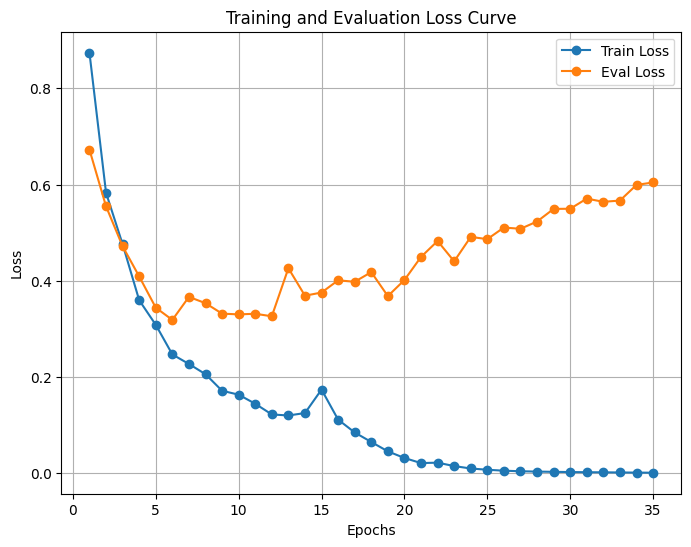

Training curve visualization completed.


In [25]:
# Lets train the base model
train(base_model, optimizer, criterion, train_dataloader, eval_dataloader, epochs=max_epochs, device=device)

### **Question 2.3**

Now, we will implement the `LoRALinear` layer as a replacement for the standard `Linear` layer. This involves defining the following LoRA-specific parameters:
- `low_rank_A`
- `low_rank_B`
- `rank`

Additionally, we also includes the necessary code to facilitate training.

**Question:**
Explain your observations regarding the training behavior and performance on the new 'LoRAMLP'

---

**Answer your observations here:**


Initially, both training and evaluation loss decrease, showing good learning progress. However, as training continues, the training loss becomes very low while the evaluation loss starts rising and fluctuating. This suggests overfitting—the model memorizes the training data but fails to generalize well to unseen data. The excessive number of parameters allows it to fit the training set too closely, rather than capturing broader patterns.

In [26]:
import torch.nn as nn

class LoRALinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, rank: int, bias: bool = True) -> None:
        """
        LoRALinear layer with low-rank adaptation.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            rank (int): Rank of the low-rank matrices for LoRA.
            bias (bool): Whether to include a bias term.
        """
        super().__init__(in_features, out_features, bias=bias)

        # LoRA-specific parameters
        ### Complete the following code of low_rank_A, low_rank_B and rank
        self.low_rank_A = nn.Parameter(torch.zeros((out_features, rank)))
        self.low_rank_B = nn.Parameter(torch.zeros((rank, in_features)))
        self.rank = rank

        # Initialize LoRA parameters
        self.reset_lora_parameters()

    def reset_lora_parameters(self) -> None:
        """Initialize LoRA-specific parameters."""
        nn.init.kaiming_uniform_(self.low_rank_A, a=5 ** 0.5)
        nn.init.kaiming_uniform_(self.low_rank_B, a=5 ** 0.5)

    def forward(self, input):
        """
        Perform forward pass with LoRA adaptation.

        Args:
            input (Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            Tensor: Output tensor of shape (batch_size, out_features).
        """
        ### Complete the following code of computing adapted weight: Original weight + low-rank update
        lora_update = torch.matmul(self.low_rank_A, self.low_rank_B)
        adapted_weight = self.weight + lora_update
        return torch.nn.functional.linear(input, adapted_weight, self.bias)

class LoRA_MLP(nn.Module):
    def __init__(self, lora_rank: int) -> None: # Default rank for LoRA
        super().__init__()
        ### Complete the following code of: LoRA_MLP
        ### Use the created LoRALinear
        self.seq = nn.Sequential(
            LoRALinear(20, 2048, rank=lora_rank, bias=True),
            nn.ReLU(),
            LoRALinear(2048, 2048, rank=lora_rank, bias=True),
            nn.ReLU(),
            LoRALinear(2048, 2, rank=lora_rank, bias=True),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.seq(X)


In [27]:
def freeze_non_lora_parameters(model):
    ### Complete the following code of: freezing none lora parameters,
    ### consider also make the last linear layer trainable
    for name, param in model.named_parameters():
        if 'low_rank_A' in name and 'low_rank_B' in name:
            param.requires_grad = True
        elif 'seq.4' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

In [28]:
# use it
lora_model = LoRA_MLP(lora_rank=8).to(device)  # You can adjust the rank as needed
freeze_non_lora_parameters(lora_model)
print_trainable_parameters(lora_model)
##
optimizer = torch.optim.Adam(lora_model.parameters(), lr=lr)

trainable params: 20498 || all params: 4309170 || trainable%: 0.47568325222722707


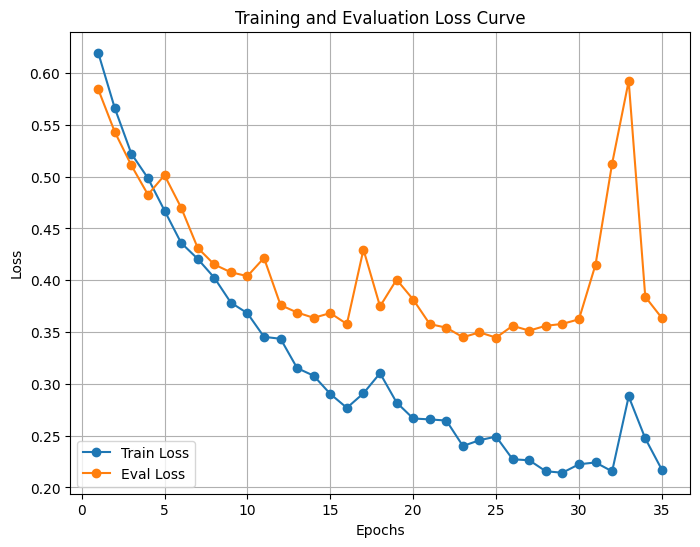

Training curve visualization completed.


In [29]:
train(lora_model, optimizer, criterion, train_dataloader, eval_dataloader, device=device, epochs=max_epochs)

## **Introduction to PEFT (Parameter-Efficient Fine-Tuning)**

In this lab, we’ve manually implemented LoRA for fine-tuning very simple MLP and Linear but this adapatation can be tedious to manage custom layers, weight transfers, and freezing parameters.

Instead, we can use **Hugging Face's PEFT (Parameter-Efficient Fine-Tuning)** library. PEFT provides tools to easily integrate techniques like LoRA into your training pipeline without writing custom implementations. It automates tasks such as:
- Adding low-rank layers to the model.
- Freezing non-LoRA parameters.
- Managing weight transfers and training only the LoRA-specific parameters.

In the next part of this lab, we redo everything with peft library.

In [30]:
!pip install peft

In [31]:
import peft
import copy

We list all names of the modules to decide which put into lora config

In [32]:
[(n, type(m)) for n, m in MLP().named_modules()]

[('', __main__.MLP),
 ('seq', torch.nn.modules.container.Sequential),
 ('seq.0', torch.nn.modules.linear.Linear),
 ('seq.1', torch.nn.modules.activation.ReLU),
 ('seq.2', torch.nn.modules.linear.Linear),
 ('seq.3', torch.nn.modules.activation.ReLU),
 ('seq.4', torch.nn.modules.linear.Linear),
 ('seq.5', torch.nn.modules.activation.LogSoftmax)]

Next we can define the LoRA config. There is nothing special going on here. We set the LoRA rank to 8 and select the layers `seq.0` and `seq.2` to be used for LoRA fine-tuning. As for `seq.4`, which is the output layer, we set it as `module_to_save`, which means it is also trained but no LoRA is applied.

In [33]:
config = peft.LoraConfig(
    r=2,
    target_modules=["seq.0", "seq.2"],
    modules_to_save=["seq.4"],
)

In [34]:
module = MLP().to(device)
peft_model = peft.get_peft_model(module, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
criterion = nn.NLLLoss()

Now you can complete train the LoRA with `peft_model` directly, **complete the code.**

trainable params: 16,426 || all params: 4,259,884 || trainable%: 0.3856


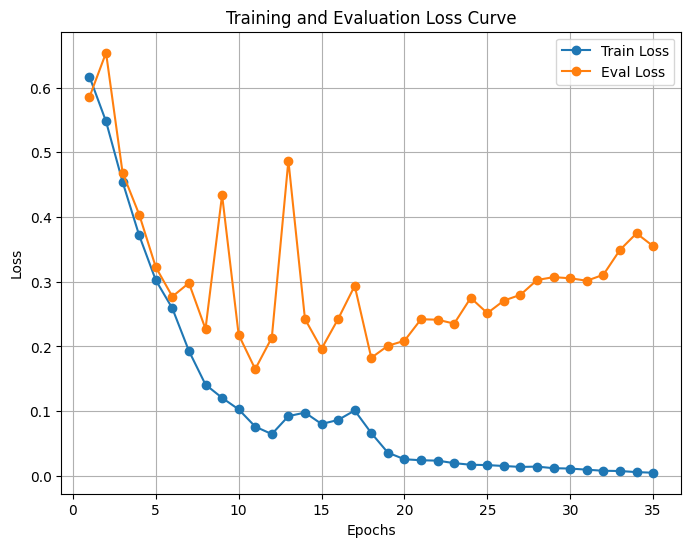

Training curve visualization completed.


In [35]:
### Complete the following code:
peft_model.print_trainable_parameters()
train(
    peft_model,
    optimizer,
    criterion,
    train_dataloader,
    eval_dataloader,
    max_epochs,
    device
) ### Complete me

### **Using LoRA to fine-tune CLIP**


### Reuse dataset Food101
Implement the dataset class for UPMC-Food101 dataset.
For this, you will need to:
- Download the data [here](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing)
- Split it in train, val, test sets using the following ratios: 0.7, 0.1, 0.2.
- Create a dataset class inherited from `torch.utils.data.Dataset` that loads the data, and preprocesses it.

Tips:
1. In `PyTorch`, the dataset class should inherint from [`torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/data_loading_tutorial#dataset-class) and always override:
- `__len__`: so that `len(dataset)` returns the size of the dataset.
- `__getitem__`: to support the indexing such that `dataset[i]` can be used to get the `i`-th sample.


2. If you use colab, to ease the access to the data, you can mount your google drive and access the data from there.
- *Mount your Google Drive* to allow Colab to access files in your Drive.
```python
from google.colab import drive
drive.mount('/content/drive')
```
- Access the [file](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing) with the data, this will automatically add it to your 'shared folder'
- Locate the Shared Folder which is typically stored under My Drive > Shared with me. (However, only items in "My Drive" or folders you’ve added to your Drive can be accessed directly.)
- Add the Shared Folder to 'My Drive'. Drag & drop the folder in 'My Drive' folder.
- The folder with the data should now be in My Drive/LabeledDB_new
- It should now be located in the path '/content/drive/My Drive/food101.arrow'

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
DATA_DIR = "/content/drive/MyDrive/" # TODO: Change this to your data path

In [38]:
!pip install peft
!pip install pyarrow

import os
import io
import pyarrow as pa
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm


import numpy as np
from matplotlib import pyplot as plt

from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
)

from transformers import CLIPProcessor, CLIPModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
def open_arrow(data_dir, name):
    path = os.path.join(data_dir, f"{name}.arrow")
    # Debugging: Print path to verify correctness
    print(f"Looking for file: {path}")

    if not os.path.isfile(path):
        raise FileNotFoundError(f"Dataset file '{path}' not found. Check your DATA_DIR setting.")

    assert os.path.isfile(path)
    table = pa.ipc.RecordBatchFileReader(
        pa.memory_map(path, "r")
    ).read_all()
    all_texts = table["text"].to_pandas().to_list()
    all_texts = [text[0] for text in all_texts]
    all_images = table["image"].to_pandas().to_list()
    all_labels = table["label"].to_pandas().to_list()
    return all_texts, all_images, all_labels
CLASSES_FOOD101 = [
        "frozen yogurt", "tacos","gnocchi", "ramen", "sushi", "spaghetti carbonara", "foie gras", "club sandwich",
        "chicken curry", "caprese salad", "guacamole", "fish and chips", "seaweed salad", "samosa", "shrimp and grits",
        "prime rib", "cheese plate", "grilled cheese sandwich", "omelette", "macarons", "pancakes", "paella",
        "crab cakes", "onion rings", "poutine", "panna cotta", "hamburger", "eggs benedict", "pizza", "cup cakes",
        "red velvet cake", "huevos rancheros", "french toast", "pad thai","beef tartare", "beet salad",
        "garlic bread", "escargots", "cheesecake", "tuna tartare", "french fries", "pulled pork sandwich", "ravioli",
        "clam chowder", "baby back ribs", "pork chop", "chicken quesadilla", "grilled salmon", "dumplings",
        "fried rice", "macaroni and cheese", "hot and sour soup", "tiramisu",  "lobster_roll_sandwich",
        "filet mignon",  "lobster bisque",  "risotto",  "takoyaki",  "waffles",  "miso soup",  "scallops",
        "hummus", "french onion soup", "spaghetti bolognese", "gyoza", "sashimi", "caesar salad",
        "donuts", "pho", "creme brulee", "edamame","apple pie", "carrot cake", "croque madame",
        "chocolate_cake", "mussels", "chocolate mousse", "deviled eggs", "ice cream",
        "chicken_wings", "steak", "churros", "beignets", "breakfast burrito", "spring rolls",
        "lasagna", "cannoli", "nachos", "bruschetta", "hot dog", "greek salad", "beef carpaccio",
        "falafel", "strawberry shortcake", "bread pudding", "ceviche", "peking duck",
        "bibimbap", "oysters", "fried calamari", "baklava"
    ]

Use directly the code from last week.

In [40]:
class MultimodalDataset(torch.utils.data.Dataset):
    """Food101 dataset."""

    def __init__(
        self,
        path: str,
        name: str,
        split: str = None,
        img_transforms = None,
    ) -> None:
        """Initialize Food101 dataset.

        Parameters
        ----------
        path : str
            Path where the dataset is stored.
        name: str
            Name of the file to load.
        split : str, optional
            Split to use, by default None.
        img_transforms : torchvision.transforms, optional
            Image transformations, by default None.
        split : str, optional
            split to use, e.g. "train", "val", "test".
        """
        super().__init__()
        # To complete
        self.path = path
        self.name = name
        self.split = split
        self.img_transforms = img_transforms

        all_texts, all_images, all_labels = open_arrow(path, name)
        data = list(zip(all_texts, all_images, all_labels))
        random.shuffle(data)
        all_texts, all_images, all_labels = zip(*data)
        total_len = len(all_images)
        indices = list(range(total_len))
        random.shuffle(indices)
        dataset_size = len(data)
        train_end = int(0.7 * dataset_size)
        val_end = int(0.8 * dataset_size)

        if split == "train":
            self.data = data[:train_end]
        elif split == "val":
            self.data = data[train_end:val_end]
        elif split == "test":
            self.data = data[val_end:]
        else:
            self.data = data

    def open_arrow(self, data_dir, name):
        path = os.path.join(data_dir, f"{name}.arrow")
        assert os.path.isfile(path), f"File {path} does not exist!"
        table = pa.ipc.RecordBatchFileReader(
            pa.memory_map(path, "r")
        ).read_all()

        all_texts = table["text"].to_pandas().to_list()
        all_texts = [text[0] if isinstance(text, (list, tuple)) else text for text in all_texts]
        all_images = table["image"].to_pandas().to_list()
        all_labels = table["label"].to_pandas().to_list()
        return all_texts, all_images, all_labels

    def __len__(self) -> int:
        """Len of the dataset."""
        # To complete
        return len(self.data)

    def __getitem__(self, index: int):
        """Get one item from the dataset of the given index.

        Parameters
        ----------
        index : int
            Index of the item to get.
        """
        # To complete
        text, image_bytes, label = self.data[index]
        image_bytes = io.BytesIO(image_bytes)
        image_bytes.seek(0)
        image = Image.open(image_bytes).convert("RGB")

        if self.img_transforms is not None:
            image = self.img_transforms(image)

        return image, text, label

Make sure the dataset works fine.

Looking for file: /content/drive/MyDrive/food101.arrow


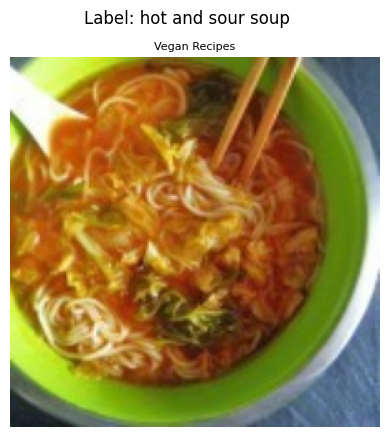

In [41]:
im_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])
idx = 2
dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=im_transforms,)
# - display one image
image, text_value, label  = dataset[idx]
plt.imshow(image.numpy().transpose(1, 2, 0))
plt.suptitle(f'Label: {CLASSES_FOOD101[label]}')
plt.title(text_value, fontsize=8)
plt.axis('off')
plt.show()

Again we evaluate the zero-shot performance of the CLIP model on the UPMC-Food101 dataset. Use `clip.tokenize(text_labels)` to tokenize the text labels and `clip.load("ViT-B/32", device=device)[0]` to load the CLIP pretrained model.

In [42]:
img_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
        ),
    ])

test_set_food = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=img_transforms)
test_loader_food = torch.utils.data.DataLoader(test_set_food, batch_size=128, shuffle=False)

Looking for file: /content/drive/MyDrive/food101.arrow


In [43]:

def evaluate_clip_multimodal_hf(model, processor, test_loader, classes, prefix, device):
    """
    Evaluate a CLIP model (Hugging Face) on a classification task.

    Args:
        model (CLIPModel): A Hugging Face CLIP model.
        processor (CLIPProcessor): A Hugging Face CLIP processor for tokenizing and image preprocessing.
        test_loader (DataLoader): DataLoader for the test set, yielding (images, _, labels).
        classes (list): List of class labels.
        prefix (str): Text prefix for prompt engineering (e.g., "A photo of a").
        device (torch.device): The device (CPU or GPU) to perform evaluation on.
    """
    # Prepare text prompts (labels)
    text_labels = [f"{prefix}{c}" for c in classes]  # e.g., "A photo of a dog"

    # Tokenize text labels with HF processor
    text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)

    test_acc = 0.0
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images, _, labels = batch
            labels = labels.to(device)

            # Preprocess images
            image_inputs = processor(images=images, return_tensors="pt",
                                     do_normalize=False, do_resize=False, do_rescale=False,).to(device)

            outputs = model(**image_inputs, **text_inputs)
            logits_per_image = outputs.logits_per_image  # (batch_size, num_classes)

            probs = logits_per_image.softmax(dim=-1).cpu()
            predicted = probs.argmax(dim=-1)

            test_acc += (predicted == labels.cpu()).sum().item()
            all_labels.append(labels.cpu())
            all_predictions.append(predicted)

    test_acc /= len(test_loader.dataset)
    print(f"Test Acc: {test_acc:.3f}")

# Initialize the Hugging Face CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Evaluate the model
evaluate_clip_multimodal_hf(
    model=model,
    processor=processor,
    test_loader=test_loader_food,
    classes=CLASSES_FOOD101,
    prefix="",
    device=device
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

100%|██████████| 36/36 [00:35<00:00,  1.03it/s]

Test Acc: 0.611


### Question 2.4:
Now we use the peft library to fine-tune our clip more efficiently.


In [44]:
batch_size=128
im_transforms_train = torchvision.transforms.Compose(
    [transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop but keep most of food visible
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        IMAGENET_DEFAULT_MEAN,
        IMAGENET_DEFAULT_STD
    ), ]
    )
im_transforms = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
    ),
])
dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="train",
                            img_transforms=im_transforms_train)
test_dataset = MultimodalDataset(path=DATA_DIR,
                        name="food101",
                        split="test",
                        img_transforms=im_transforms)
val_dataset = MultimodalDataset(path=DATA_DIR,
                                name="food101",
                                split="val",
                                img_transforms=im_transforms)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        drop_last=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            drop_last=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=False)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

Looking for file: /content/drive/MyDrive/food101.arrow
Looking for file: /content/drive/MyDrive/food101.arrow
Looking for file: /content/drive/MyDrive/food101.arrow


In [47]:
def train_clip_lora(
    model: CLIPModel,
    processor: CLIPProcessor,
    train_loader: DataLoader,
    val_loader: DataLoader,
    classes: list,
    epochs: int = 5,
    lr: float = 1e-3,
    prefix: str = "",
) -> None:

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )
    criterion = nn.CrossEntropyLoss()
    text_labels = [f"{prefix}{c}" for c in classes]
    text_inputs = processor(text=text_labels, return_tensors="pt", padding=True)

    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for images, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images = images.to(device)
            labels = labels.to(device)

            image_inputs = processor(images=images, return_tensors="pt",
                                     do_normalize=False, do_resize=False, do_rescale=False)
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

            outputs = model(**image_inputs, **text_inputs)
            logits = outputs.logits_per_image
            loss = criterion(logits, labels)
            total_train_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            total_train_correct += (preds == labels).sum().item()
            total_train_samples += images.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / total_train_samples
        train_acc = total_train_correct / total_train_samples

        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        with torch.no_grad():
            for images, texts, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images = images.to(device)
                labels = labels.to(device)
                image_inputs = processor(images=images, return_tensors="pt",
                                         do_normalize=False, do_resize=False, do_rescale=False)
                image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
                outputs = model(**image_inputs, **text_inputs)
                logits = outputs.logits_per_image
                loss = criterion(logits, labels)
                total_val_loss += loss.item() * images.size(0)
                preds = logits.argmax(dim=1)
                total_val_correct += (preds == labels).sum().item()
                total_val_samples += images.size(0)
        avg_val_loss = total_val_loss / total_val_samples
        val_acc = total_val_correct / total_val_samples

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [48]:
from peft import LoraConfig, get_peft_model, TaskType
# device="cpu"
# Example LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Adjust to match your model's layer names
    lora_dropout=0.1,
    bias="none",
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32",
                                  torch_dtype=torch.float16).to(device)

lora_model = get_peft_model(model, lora_config)
print_trainable_parameters(lora_model)

print(len(CLASSES_FOOD101))

#Fine-tune with LoRA
train_clip_lora(
    model=lora_model,
    processor=processor,
    train_loader=dataloader,
    val_loader=val_dataloader,
    classes=CLASSES_FOOD101,
    epochs=5,
    lr=1e-3,
    prefix=""  # example prompt, try also the prompting if you want
)


trainable params: 983040 || all params: 152260353 || trainable%: 0.6456309739410626
101


Epoch 1/5 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


[Epoch 1] Train Loss: 1.4623, Train Acc: 0.6507 | Val Loss: 1.2433, Val Acc: 0.6966


Epoch 2/5 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


[Epoch 2] Train Loss: 1.2705, Train Acc: 0.6898 | Val Loss: 1.1171, Val Acc: 0.7248


Epoch 3/5 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


[Epoch 3] Train Loss: 1.1465, Train Acc: 0.7139 | Val Loss: 1.0506, Val Acc: 0.7424


Epoch 4/5 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


[Epoch 4] Train Loss: 1.0528, Train Acc: 0.7281 | Val Loss: 1.0073, Val Acc: 0.7490


Epoch 5/5 [Val]: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]

[Epoch 5] Train Loss: 0.9481, Train Acc: 0.7527 | Val Loss: 0.9115, Val Acc: 0.7710


Evaluate your lora-model to see if the lora helps the tuning.

In [49]:
evaluate_clip_multimodal_hf(
    model=lora_model,
    processor=processor,
    test_loader=test_loader_food,
    classes=CLASSES_FOOD101,
    prefix="",
    device=device
)

100%|██████████| 36/36 [00:34<00:00,  1.05it/s]

Test Acc: 0.760
